In [165]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import sklearn as sk
import os, glob, shutil, math, time


def data_rescale(scaled_dat,train_mean,train_var):
    d = np.shape(train_mean)[0]
    #print('unnormalizing with number of dimensions = ' +str(d))
    dat = (np.multiply(scaled_dat,np.sqrt(train_var))) + train_mean.T
    return(dat)
def data_normalize(data,train_mean,train_var):
    d = np.shape(train_mean)[0]
    print('normalizing with number of dimensions = ' +str(d))
    scaled_dat = np.divide((data - train_mean.T),np.sqrt(train_var),)
    return(scaled_dat)
    


In [166]:
data = pd.read_csv("working_matrix.csv",sep=",")


In [167]:
forbid_names = ['comb_2_0']
for forb in forbid_names:
    data  =  data.loc[data['Unnamed: 0']  != forb]

In [168]:

## seed 
np.random.seed(4)
# get random partition
msk = np.random.rand(np.shape(data)[0]) < 0.8


# test and train split
train_data = data[msk]
test_data = data[~msk]

In [169]:
# get 
feature_names=[]
for ft in df.columns:
    if ft.find('COF') ==-1  and ft.find('Unnamed: 0') ==-1 and ft.find('OFR') ==-1:
            feature_names.append(ft)
print(feature_names)

['f.chi.0.all', 'f.chi.1.all', 'f.chi.2.all', 'f.chi.3.all', 'f.chi.4.all', 'f.Z.0.all', 'f.Z.1.all', 'f.Z.2.all', 'f.Z.3.all', 'f.Z.4.all', 'f.I.0.all', 'f.I.1.all', 'f.I.2.all', 'f.I.3.all', 'f.I.4.all', 'f.T.0.all', 'f.T.1.all', 'f.T.2.all', 'f.T.3.all', 'f.T.4.all', 'f.S.0.all', 'f.S.1.all', 'f.S.2.all', 'f.S.3.all', 'f.S.4.all', 'con.chi.0.all', 'con.chi.1.all', 'con.chi.2.all', 'con.chi.3.all', 'con.chi.4.all', 'con.chi.5.all', 'con.Z.0.all', 'con.Z.1.all', 'con.Z.2.all', 'con.Z.3.all', 'con.Z.4.all', 'con.Z.5.all', 'con.I.1.all', 'con.I.2.all', 'con.I.3.all', 'con.I.4.all', 'con.I.5.all', 'con.T.0.all', 'con.T.1.all', 'con.T.2.all', 'con.T.3.all', 'con.T.4.all', 'con.T.5.all', 'con.S.0.all', 'con.S.1.all', 'con.S.2.all', 'con.S.3.all', 'con.S.4.all', 'con.S.5.all']


In [170]:
# COFs
train_data_y = train_data['COF']
test_data_y = test_data['COF']
# xvales
train_data_x = train_data[feature_names].values
test_data_x = test_data[feature_names].values
## data generation
m = np.shape(train_data_x)[0]
d = np.shape(train_data_x)[1]
p = 1
# normalization
train_var_x = np.var(train_data_x,0)
train_mean_x = np.mean(train_data_x,0).reshape(d,1).squeeze()
train_var_y = np.var(train_data_y,0).reshape(1)
train_mean_y = np.mean(train_data_y,0).reshape(1)
# scale
scaled_train_data_x = data_normalize(train_data_x,train_mean_x,train_var_x)
scaled_train_data_y = data_normalize(train_data_y,train_mean_y,train_var_y)
scaled_test_data_x = data_normalize(test_data_x,train_mean_x,train_var_x)
scaled_test_data_y = data_normalize(test_data_y,train_mean_y,train_var_y)

normalizing with number of dimensions = 54
normalizing with number of dimensions = 1
normalizing with number of dimensions = 54
normalizing with number of dimensions = 1


In [171]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(scaled_train_data_x,scaled_train_data_y)



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [172]:
pred_train_cofs = data_rescale(reg.predict(scaled_train_data_x),train_mean_y,train_var_y)
real_train_cofs =  data_rescale(scaled_train_data_y,train_mean_y,train_var_y)
pred_test_cofs = data_rescale(reg.predict(scaled_test_data_x),train_mean_y,train_var_y)
real_test_cofs =  data_rescale(scaled_test_data_y,train_mean_y,train_var_y)
def rms(val):
    return(np.sqrt(np.mean(np.power(val,2))))
print('linear model TRAIN error is ' + str(rms(pred_train_cofs-real_train_cofs)))
print('linear model TEST error is ' + str(rms(pred_test_cofs-real_test_cofs)))

linear model TRAIN error is 0.00287014847169
linear model TEST error is 0.00734600505549


Text(0,0.5,'pred')

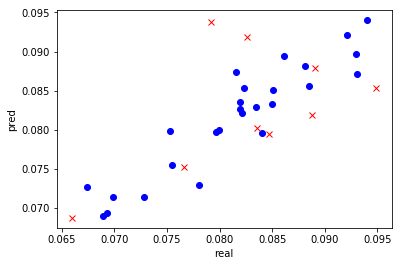

In [173]:
plt.plot(real_train_cofs,pred_train_cofs,'bo')
plt.plot(real_test_cofs,pred_test_cofs,'rx')
plt.xlabel('real')
plt.ylabel('pred')

In [174]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

In KRR!
In KRR loop!
Best parameters set found on development set:
()
{'alpha': 9.9999999999999995e-08, 'gamma': 1e-08, 'kernel': 'rbf'}
()
Grid scores on development set:
()
('Chosen Alpha: ', 9.9999999999999995e-08)
('Chosen Gamma: ', 1e-08)


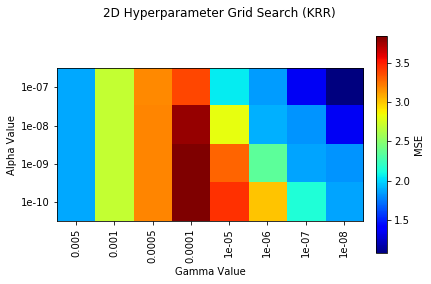

In [175]:
print('In KRR!')
Cs = np.array([0.0000001,0.00000001,0.000000001,0.0000000001])
Gammas = np.array([0.005, 0.001, 0.0005, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001])
#Gammas = np.array(np.linspace(start=1,stop=200,num=20))
nus = np.array([1])

tuned_parameters = [{'kernel': ['rbf'], 'gamma': Gammas, 'alpha': Cs}]
reshapedy = np.squeeze(scaled_train_data_y)

fig, axs = plt.subplots(1,1, facecolor='w', edgecolor='k',squeeze=False)
fig.subplots_adjust(hspace = .3, wspace= 1)
axs = axs.ravel()
for i, nu in enumerate(nus):
    print('In KRR loop!')
    clf = GridSearchCV(KernelRidge(), tuned_parameters, cv=10, scoring='neg_mean_absolute_error')
    clf.fit(scaled_train_data_x, reshapedy)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    #    print()
    scores = -(clf.cv_results_['mean_test_score'].reshape(len(Cs),len(Gammas)))
    im = axs[i].imshow(scores, interpolation='nearest', cmap=plt.cm.jet)
    axs[i].set_xticks(np.arange(len(Gammas)))
    axs[i].set_yticks(np.arange(len(Cs)))
    axs[i].set_xticklabels(['{:g}'.format(float('{:.3g}'.format(j))) for j in tuned_parameters[0]['gamma']])
    axs[i].set_yticklabels(['{:g}'.format(float('{:.3g}'.format(j))) for j in tuned_parameters[0]['alpha']])
    axs[i].set_xlabel('Gamma Value')
    axs[i].set_ylabel('Alpha Value')
    # axs[i].set_title('Nu = '+str(nu))
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)
    cbar = fig.colorbar(im, ax = axs[i], fraction=0.046, pad=0.04)#,boundaries = np.linspace(0.3, 0.8, 21))
    cbar.set_label('MSE')
    fig.suptitle('2D Hyperparameter Grid Search (KRR)')
    print('Chosen Alpha: ', clf.best_params_['alpha'])
    print('Chosen Gamma: ', clf.best_params_['gamma'])
    final_model = KernelRidge(kernel = 'rbf', alpha = clf.best_params_['alpha'], gamma = clf.best_params_['gamma'])


In [162]:
final_model.fit(scaled_train_data_x, scaled_train_data_y)
krr_train_cofs = data_rescale(final_model.predict(scaled_train_data_x),train_mean_y,train_var_y)
real_train_cofs =  data_rescale(scaled_train_data_y,train_mean_y,train_var_y)
krr_test_cofs = data_rescale(final_model.predict(scaled_test_data_x),train_mean_y,train_var_y)
real_test_cofs =  data_rescale(scaled_test_data_y,train_mean_y,train_var_y)
print('KRR model TRAIN error is ' + str(rms(krr_train_cofs-real_train_cofs)))
print('KRR model TEST error is ' + str(rms(krr_test_cofs-real_test_cofs)))

KRR model TRAIN error is 0.00667443818954
KRR model TEST error is 0.00762485148799


In [163]:
linear model TRAIN error is 0.00200541838387
linear model TEST error is 0.0107625607629

SyntaxError: invalid syntax (<ipython-input-163-a5b73acb6d3d>, line 1)

Text(0,0.5,'pred')

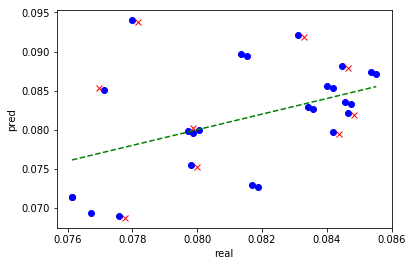

In [164]:
plt.plot(krr_train_cofs,pred_train_cofs,'bo')
plt.plot(krr_test_cofs,pred_test_cofs,'rx')
#plt.axvline(x=np.mean(train_data['COF']))
plt.plot(np.linspace(min(krr_train_cofs),max(krr_train_cofs)),np.linspace(min(krr_train_cofs),max(krr_train_cofs)),'g--')
plt.xlabel('real')
plt.ylabel('pred')